In [1]:
import pandas as pd
#pd.set_option('display.max_columns', None)#, 'display.max_rows', None)
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import uniform, randint
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.metrics import hinge_loss

from sklearn.calibration import CalibratedClassifierCV
import random
random.seed(1995)

import datetime
import time
import pickle

import warnings
warnings.filterwarnings('ignore') # Used for a deprecation warning on XGBoost

import json

# Loading and processing data

In [2]:
# Read in data, and display first 5 rows
coupon = pd.read_csv('Coupon_data/train.csv')
coupon.head()

,id,Decision,Driving_to,Passanger,Weather,Temperature,Time,Coupon,Coupon_validity,Gender,...,Education,Occupation,Income,Bar,Coffeehouse,Carryaway,Restaurantlessthan20,Restaurant20to50,Direction_same,Distance
0,1,1,No Urgent Place,Partner,Sunny,80,6PM,Bar,1d,Male,...,Some college - no degree,Construction & Extraction,$100000 or More,2.0,0.0,3.0,2.0,2.0,0,2
1,2,0,Work,Alone,Sunny,80,7AM,Restaurant(20-50),1d,Female,...,Some college - no degree,Unemployed,$62500 - $74999,0.0,1.0,4.0,3.0,0.0,0,2
2,3,1,No Urgent Place,Partner,Sunny,80,6PM,Restaurant(<20),1d,Male,...,Associates degree,Unemployed,$37500 - $49999,1.0,1.0,1.0,3.0,1.0,0,1
3,4,1,Work,Alone,Sunny,55,7AM,Restaurant(<20),1d,Male,...,Some college - no degree,Construction & Extraction,$100000 or More,2.0,0.0,3.0,2.0,2.0,0,1
4,5,1,Home,Alone,Sunny,30,6PM,Carry out & Take away,2h,Male,...,Some college - no degree,Arts Design Entertainment Sports & Media,$12500 - $24999,0.0,0.0,2.0,2.0,0.0,1,2


In [3]:
# View original data types
coupon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10184 entries, 0 to 10183
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10184 non-null  int64  
 1   Decision              10184 non-null  int64  
 2   Driving_to            10184 non-null  object 
 3   Passanger             10184 non-null  object 
 4   Weather               10184 non-null  object 
 5   Temperature           10184 non-null  int64  
 6   Time                  10184 non-null  object 
 7   Coupon                10184 non-null  object 
 8   Coupon_validity       10184 non-null  object 
 9   Gender                10184 non-null  object 
 10  Age                   10184 non-null  object 
 11  Maritalstatus         10184 non-null  object 
 12  Children              10184 non-null  int64  
 13  Education             10184 non-null  object 
 14  Occupation            10184 non-null  object 
 15  Income             

The following function produces the dataset that was ultimately used for analysis and modeling. As discussed in the "Exploratory Analysis" portion of the report, variants of this process were also attempted. For brevity and the sake of providing clean code, only the final version is shown here.

In [4]:
def process_data(df):
    
    """Creates single pipeline for transforming training and testing data into format used for modeling.
    Modifications include (1) changing data types, (2) dropping the 'id' column, and (3) performing
    minimal feature engineering"""
    
    # Fill NA values with text 'NA', which will create a new category. There were previously 495 observations
    # with at least one NA value
    df = df.fillna('NA')
    
    # Convert all columns to category type 
    df = df.astype('category')

    # Apply ordering to select columns
    temp_type = CategoricalDtype(categories=[30, 55, 80], ordered=True)
    coupon_val_type = CategoricalDtype(categories=["2h", "1d"], ordered=True)
    age_type = CategoricalDtype(categories=["below21", "21", "26", "31", "36", "41", "46", "50plus"], \
                                ordered=True)
    education_type = CategoricalDtype(categories=["Some High School", "High School Graduate", \
                                                  "Some college - no degree", "Associates degree", \
                                                  "Bachelors degree", "Graduate degree (Masters or Doctorate)"], \
                                      ordered=True)
    income_type = CategoricalDtype(categories=["Less than $12500", "$12500 - $24999", "$25000 - $37499", \
                                              "$37500 - $49999", "$50000 - $62499", \
                                              "$62500 - $74999", "$75000 - $87499", \
                                              "$87500 - $99999", "$100000 or More"], ordered=True)
    freq_type = CategoricalDtype(categories=['NA', 0.0, 1.0, 2.0, 3.0, 4.0], ordered=True)
    distance_type = CategoricalDtype(categories=[1, 2, 3], ordered=True)
    df = df.astype({'Temperature': temp_type, 'Coupon_validity': coupon_val_type, 'Age': age_type, \
                            'Education': education_type, 'Income': income_type, 'Bar': freq_type, \
                            'Coffeehouse': freq_type, 'Carryaway': freq_type, 'Restaurantlessthan20': freq_type, \
                            'Restaurant20to50': freq_type, 'Distance': distance_type})

    # Remove id column
    df = df.drop(columns = 'id')
    
    # Add Coupon_category_rating feature
    conditions = [df['Coupon'] == 'Bar', \
                 df['Coupon'] == 'Carry out & Take away', \
                 df['Coupon'] == 'Coffee House', \
                 df['Coupon'] == 'Restaurant(20-50)', \
                 df['Coupon'] == 'Restaurant(<20)']
    outputs = [df['Bar'], df['Carryaway'], df['Coffeehouse'], df['Restaurant20to50'], \
              df['Restaurantlessthan20']]
    df['Coupon_category_rating'] = np.select(conditions, outputs, 'Other')
    
    # Return processed df
    return df

In [5]:
# Pre-process the training data
coupon1 = process_data(coupon)
coupon1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10184 entries, 0 to 10183
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Decision                10184 non-null  category
 1   Driving_to              10184 non-null  category
 2   Passanger               10184 non-null  category
 3   Weather                 10184 non-null  category
 4   Temperature             10184 non-null  category
 5   Time                    10184 non-null  category
 6   Coupon                  10184 non-null  category
 7   Coupon_validity         10184 non-null  category
 8   Gender                  10184 non-null  category
 9   Age                     10184 non-null  category
 10  Maritalstatus           10184 non-null  category
 11  Children                10184 non-null  category
 12  Education               10184 non-null  category
 13  Occupation              10184 non-null  category
 14  Income                

In [6]:
# Show counts and observed incidence of Decision = 1 for each category within each variable
for col in coupon1.columns[1:]:
    print(coupon1[[col, 'Decision']].groupby(col).agg(['count', np.average]))
    print('')

                Decision          
                   count   average
Driving_to                        
Home                2595  0.502890
No Urgent Place     5085  0.635988
Work                2504  0.505192

          Decision          
             count   average
Passanger                   
Alone         5834  0.525540
Friend(s)     2678  0.677745
Kid(s)         802  0.508728
Partner        870  0.591954

        Decision          
           count   average
Weather                   
Rainy        988  0.461538
Snowy       1125  0.451556
Sunny       8071  0.599678

            Decision          
               count   average
Temperature                   
30              1850  0.522162
55              3078  0.538661
80              5256  0.605023

     Decision          
        count   average
Time                   
10AM     1851  0.601297
10PM     1609  0.502797
2PM      1595  0.672727
6PM      2625  0.588190
7AM      2504  0.505192

                      Decision          
 

In [7]:
# Find overall incidence of Decision = 1 to assess class balance / imbalance
np.average(coupon1.Decision)

0.5699135899450117

In [8]:
# ### Produce plot used in poster
# # Create plotting dataframe
# plot_df = coupon1[['Coupon', \
#                    'Decision']].groupby('Coupon').agg(['count', \
#                                                        np.average])['Decision'].sort_values('count', ascending = False)

# # Generate plot
# figure = plt.gcf()
# ax = plot_df['count'].plot(kind = 'bar')
# ax2 = plot_df['average'].plot(secondary_y=True, ax=ax)
# ax.set_ylabel('Category count')
# ax2.set_ylabel('% Decision = 1')
# x_axis = ax.axes.get_xaxis()
# x_axis.set_label_text('')
# plt.title('Figure 1 - "Coupon" variable EDA')
# for tick in ax.get_xticklabels():
#     tick.set_rotation(30)
    
# # Set image and font sizes
# figure.set_size_inches(6, 4)
# plt.rc('font', size = 20)          # controls default text sizes
# plt.rc('axes', titlesize = 20)     # fontsize of the axes title
# plt.rc('axes', labelsize = 20)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize = 20)    # fontsize of the tick labels
# plt.rc('ytick', labelsize = 20)    # fontsize of the tick labels
# plt.rc('figure', titlesize = 20)  # fontsize of the figure title

# # Change x-ticklabels
# labels = ['Coffee', 'Rest(<$20)', 'Takeout', 'Bar', 'Rest($20-50)']
# plt.xticks([0, 1, 2, 3, 4], labels, rotation='vertical')

# # Save plot
# plt.savefig('Images/coupon_EDA_large.png', bbox_inches = 'tight')

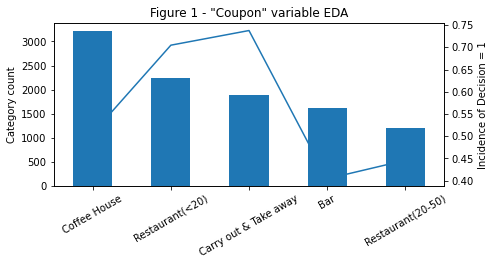

In [9]:
### Produce plot used in report
# Create plotting dataframe
plot_df = coupon1[['Coupon', \
                   'Decision']].groupby('Coupon').agg(['count', \
                                                       np.average])['Decision'].sort_values('count', ascending = False)

# Generate plot
figure = plt.gcf()
ax = plot_df['count'].plot(kind = 'bar')
ax2 = plot_df['average'].plot(secondary_y=True, ax=ax)
ax.set_ylabel('Category count')
ax2.set_ylabel('Incidence of Decision = 1')
x_axis = ax.axes.get_xaxis()
x_axis.set_label_text('')
plt.title('Figure 1 - "Coupon" variable EDA')
for tick in ax.get_xticklabels():
    tick.set_rotation(30)
    
# Save plot
figure.set_size_inches(7, 3)
plt.savefig('Images/coupon_EDA.png', bbox_inches = 'tight')

# Fitting models / results

#### Data preparation, cross-validation function definition

In [11]:
# Create cross-validation folds, which will be used for all algorithms
kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

# Split X and y... Also create X_dummy for SVM
def split_vars(df):
    return df.iloc[:, 1:], df.iloc[:, 0], pd.get_dummies(df.iloc[:, 1:])
X, y, X_dummy = split_vars(coupon1) # All data categorical

# Fix column name that XGBoost cannot handle
X_dummy_new = X_dummy.rename(columns = {'Coupon_Restaurant(<20)': 'Coupon_Restaurant_lt_20'})

In [12]:
def cross_val(X, y, model):
    """Perform cross-validation using given data and model
    
    INPUTS:
    X - Data to be used for training and validation
    y - Labels to be used for training and validation
    model - Model object to be trained on data
    
    OUTPUTS:
    accuracy - List of prediction accuracy values from each fold
    
    NOTE: CV folds should be created outside of this function and called kf
    """
    
    accuracy = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        accuracy.append(np.average(preds == y_test))
    return accuracy

In [13]:
# Load test data
coupon_test = pd.read_csv('Coupon_data/test.csv')
ids = coupon_test.iloc[:, 0]

# Load test labels
test_labels = pd.read_csv('Test_labels.csv')

# Prepare data for modeling
coupon_test = process_data(coupon_test)
coupon_test_dummy = pd.get_dummies(coupon_test)

# Modify test dataset for XGBoost
coupon_test_dummy_new = coupon_test_dummy.rename(columns = \
                                                 {'Coupon_Restaurant(<20)': 'Coupon_Restaurant_lt_20'})

#### SVM

In [14]:
# Define sigma_squared values to test
sigma_sq = np.array([1, 2, 4, 8, 16, 32, 64, 128])
gamma = 1 / sigma_sq

# Initialize matrix of accuracy values
accuracy_svm = np.zeros((kf.get_n_splits(X_dummy_new), len(gamma)))

# Loop through different sigma_sq values and perform CV for each
for idx, val in enumerate(gamma):
    print('Gamma =', val)
    start = time.time()
    model = SVC(kernel = 'rbf', gamma = val)
    accuracy_svm[:, idx] = cross_val(X_dummy_new, y, model)
    stop = time.time()
    print("Iteration duration:", (stop - start))

Gamma = 1.0
Iteration duration: 156.08559489250183
Gamma = 0.5
Iteration duration: 150.3586609363556
Gamma = 0.25
Iteration duration: 132.0340211391449
Gamma = 0.125
Iteration duration: 72.2910521030426
Gamma = 0.0625
Iteration duration: 65.33095026016235
Gamma = 0.03125
Iteration duration: 65.30818200111389
Gamma = 0.015625
Iteration duration: 67.1337730884552
Gamma = 0.0078125
Iteration duration: 69.284991979599


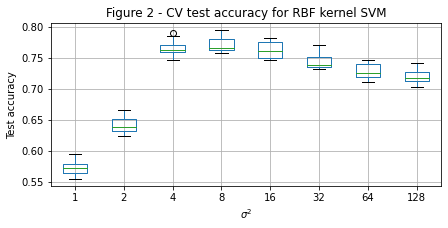

In [15]:
# Plot cross-validation results
pd.DataFrame(accuracy_svm, columns = sigma_sq).boxplot(figsize = (7, 3));
plt.xlabel('$\sigma^2$');
plt.ylabel('Test accuracy');
plt.title('Figure 2 - CV test accuracy for RBF kernel SVM');

# Save plot
plt.savefig('Images/SVM_cv.png', bbox_inches = 'tight');

In [16]:
# Fit best model
model_svm = SVC(kernel = 'rbf', gamma = 1/8, probability = True)
model_svm.fit(X_dummy_new, y);

#### Random Forest

In [19]:
# Define n_trees values to test
n_trees = [10, 50, 100, 175, 250, 500]

# Initialize matrix of accuracy values
accuracy_rf = np.zeros((kf.get_n_splits(X_dummy_new), len(n_trees)))

# Loop through different sigma_sq values and perform CV for each
for idx, val in enumerate(n_trees):
    print('Number of trees =', val)
    start = time.time()
    model = RandomForestClassifier(n_estimators = val)
    accuracy_rf[:, idx] = cross_val(X_dummy_new, y, model)
    stop = time.time()
    print("Iteration duration:", (stop - start))

Number of trees = 10
Iteration duration: 0.9421980381011963
Number of trees = 50
Iteration duration: 4.342059135437012
Number of trees = 100
Iteration duration: 8.579497814178467
Number of trees = 175
Iteration duration: 14.89770793914795
Number of trees = 250
Iteration duration: 21.138985872268677
Number of trees = 500
Iteration duration: 42.814404010772705


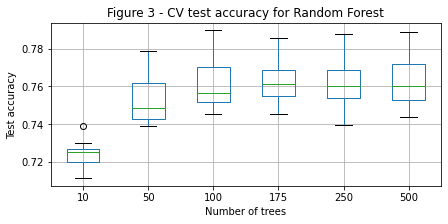

In [20]:
# Plot cross-validation results
pd.DataFrame(accuracy_rf, columns = n_trees).boxplot(figsize = (7, 3));
plt.xlabel('Number of trees');
plt.ylabel('Test accuracy');
plt.title('Figure 3 - CV test accuracy for Random Forest');

# Save plot
plt.savefig('Images/RF_cv.png', bbox_inches = 'tight');

In [21]:
# Fit best model
model_rf = RandomForestClassifier(n_estimators = 175)
model_rf.fit(X_dummy_new, y);

#### AdaBoost

In [22]:
# Set grid of n_trees and depth values to search
n_trees = [10, 50, 100, 175, 250, 500]
depth = range(1, 9)

# Initialize DataFrame of accuracy values
folds = kf.get_n_splits(X_dummy_new)
accuracy_ada = pd.DataFrame({'n_trees' : np.repeat(n_trees, folds * len(depth)), \
                            'depth' : np.tile(np.repeat(depth, folds), len(n_trees)),
                            'accuracy' : np.zeros(10 * len(depth) * len(n_trees))})

# Loop through different n_trees, depth values and perform CV for each
for idx, val in enumerate(n_trees):
    for idx2, val2 in enumerate(depth):
        print('Number of trees =', val, "... Max depth =", val2)
        start = time.time()
        model = AdaBoostClassifier(n_estimators = val, \
                                   base_estimator = DecisionTreeClassifier(max_depth = val2))
        start_index = idx * folds * len(depth) + idx2 * folds
        end_index = idx * folds * len(depth) + idx2 * folds + kf.get_n_splits(X_dummy_new) - 1
        accuracy_ada.loc[start_index:end_index, 'accuracy'] = cross_val(X_dummy_new, y, model)
        stop = time.time()
        print("Iteration duration:", (stop - start))

Number of trees = 10 ... Max depth = 1
Iteration duration: 0.8513829708099365
Number of trees = 10 ... Max depth = 2
Iteration duration: 1.3323688507080078
Number of trees = 10 ... Max depth = 3
Iteration duration: 1.8363170623779297
Number of trees = 10 ... Max depth = 4
Iteration duration: 2.30936598777771
Number of trees = 10 ... Max depth = 5
Iteration duration: 2.776823043823242
Number of trees = 10 ... Max depth = 6
Iteration duration: 3.2513551712036133
Number of trees = 10 ... Max depth = 7
Iteration duration: 3.7509829998016357
Number of trees = 10 ... Max depth = 8
Iteration duration: 4.259921073913574
Number of trees = 50 ... Max depth = 1
Iteration duration: 3.897386312484741
Number of trees = 50 ... Max depth = 2
Iteration duration: 6.484836101531982
Number of trees = 50 ... Max depth = 3
Iteration duration: 8.798183917999268
Number of trees = 50 ... Max depth = 4
Iteration duration: 11.240533113479614
Number of trees = 50 ... Max depth = 5
Iteration duration: 13.717737913

In [23]:
# Summarize results, and find hyperparameters that yield best results
avg_df = accuracy_ada.groupby(['n_trees', 'depth']).agg(np.average).reset_index()
avg_df.nlargest(5, 'accuracy').reset_index(drop = True)

,n_trees,depth,accuracy
0,250,2,0.748133
1,500,8,0.746858
2,100,3,0.745972
3,500,2,0.743323
4,175,2,0.742244


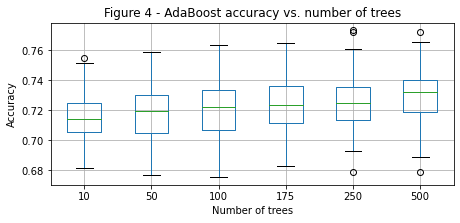

In [24]:
# Plot univariate relationships - Number of trees
accuracy_ada[['n_trees', 'accuracy']].boxplot(by = 'n_trees', figsize = (7, 3));
plt.suptitle('');
plt.xlabel('Number of trees');
plt.ylabel('Accuracy');
plt.title('Figure 4 - AdaBoost accuracy vs. number of trees');

# Save plot
plt.savefig('Images/Ada_accuracy_vs_trees.png', bbox_inches = 'tight');

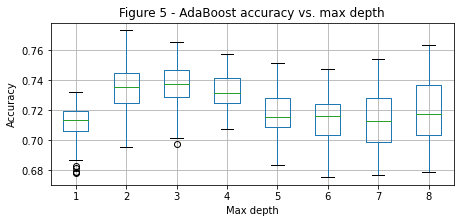

In [70]:
# Plot univariate relationships - Max depth
accuracy_ada[['depth', 'accuracy']].boxplot(by = 'depth', figsize = (7, 3));
plt.suptitle('');
plt.xlabel('Max depth');
plt.ylabel('Accuracy');
plt.title('Figure 5 - AdaBoost accuracy vs. max depth');

# Save plot
plt.savefig('Images/Ada_accuracy_vs_depth.png', bbox_inches = 'tight')

In [10]:
# Fit best model
model_ada = AdaBoostClassifier(n_estimators = 250, \
                                   base_estimator = DecisionTreeClassifier(max_depth = 2))
model_ada.fit(X_dummy_new, y);

NameError: name 'X_dummy_new' is not defined

#### XGBoost

In [27]:
# Define model
model = xgb.XGBClassifier(objective = 'binary:logistic', random_state = 0, eval_metric = 'logloss')

# Define valid hyperparameters
params = {'learning_rate': uniform(0.1, 0.5), 'max_depth': randint(1, 8), \
          'n_estimators': randint(50, 300)}

# Perform Randomized Search CV
search = RandomizedSearchCV(model, param_distributions = params, random_state = 0, n_iter = 500, \
                           scoring = 'accuracy', cv = 5, n_jobs = 1)
search.fit(X_dummy_new, y)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=na...
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=500, n_jobs=1,
           

In [28]:
# Visualize results
xgb_cv = pd.DataFrame(search.cv_results_).sort_values('rank_test_score').reset_index(drop = True)
xgb_cv[['param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_score']].head()

,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score
0,0.238814,6,189,0.765711
1,0.266982,7,188,0.764827
2,0.115118,7,216,0.764239
3,0.274391,5,284,0.763846
4,0.200182,7,298,0.763747


In [29]:
# Fit best model
model_xgb = search.best_estimator_ 
model_xgb.fit(X_dummy_new, y);

#### Prediction aggregation

In [32]:
# Notice that all AdaBoost probabilities are approximately 50%, rendering these predictions useless
# for an ensemble model. We need to calibrate these probabilities
model_ada.predict_proba(X_dummy_new)[:,0][0:10]

array([0.49700957, 0.50270805, 0.49710198, 0.49821534, 0.49834462,
       0.49398802, 0.49811995, 0.49836173, 0.49892323, 0.49948693])

In [33]:
# Create separate training and validation sets
X_train2, X_val, y_train2, y_val = train_test_split(X_dummy_new, y, test_size = 0.2, random_state = 5)

In [34]:
# Calibrate AdaBoost
calibrated_ada = CalibratedClassifierCV(base_estimator = model_ada, cv = kf);
calibrated_ada.fit(X_train2, y_train2);

# Calibrate SVM
calibrated_svm = CalibratedClassifierCV(base_estimator = model_svm, cv = kf);
calibrated_svm.fit(X_train2, y_train2);

# Calibrate RF
calibrated_rf = CalibratedClassifierCV(base_estimator = model_rf, cv = kf);
calibrated_rf.fit(X_train2, y_train2);

# Calibrate XGBoost
calibrated_xgb = CalibratedClassifierCV(base_estimator = model_xgb, cv = kf);
calibrated_xgb.fit(X_train2, y_train2);

In [35]:
# Initialize results dataframe
result_df = pd.DataFrame(columns = ['Fold', 'AdaBoost', 'SVM', 'RF', 'XGB', 'Label'])

# Store predicted probabilities and labels 
for fold, (train_index, test_index) in enumerate(kf.split(X_val)):
    
    # Test / train split
    X_train, X_test = X_val.iloc[train_index, :], X_val.iloc[test_index, :]
    y_train, y_test = y_val.iloc[train_index], y_val.iloc[test_index]
    
    # Predict probabilities for each model
    ada_proba = calibrated_ada.predict_proba(X_test)[:,0]
    svm_proba = calibrated_svm.predict_proba(X_test)[:,0]
    rf_proba = calibrated_rf.predict_proba(X_test)[:,0]
    xgb_proba = calibrated_xgb.predict_proba(X_test)[:,0]
    
    # Create intermediate dataframe
    iter_df = pd.DataFrame({'Fold': np.repeat(fold, len(test_index)), \
                           'AdaBoost': ada_proba, 'SVM': svm_proba, 'RF': rf_proba, \
                           'XGB': xgb_proba, 'Label': y_test})
    
    # Concatenate df
    result_df = result_df.append(iter_df, ignore_index = True)

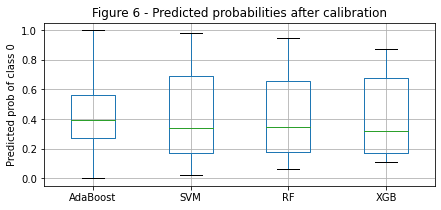

In [36]:
# Plot calibrated probabilities to visualize result of calibration
result_df[['AdaBoost', 'SVM', 'RF', 'XGB']].boxplot(figsize = (7, 3));
plt.ylabel('Predicted prob of class 0');
plt.title('Figure 6 - Predicted probabilities after calibration');
plt.savefig('Images/Calibration.png', bbox_inches = 'tight');

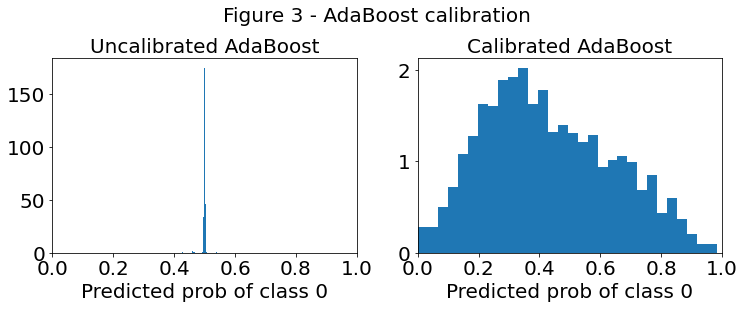

In [108]:
# # Show dramatic effect of calibration on AdaBoost predicted probabilities
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

# # Subplot 1
# test = model_ada.predict_proba(coupon_test_dummy_new)[:, 0]
# ax1.hist(test, density = True, bins = 30);
# ax1.set(xlabel = 'Predicted prob of class 0');
# ax1.set_title('Uncalibrated AdaBoost');
# ax1.set_xlim(0, 1);

# # Subplot 2
# test2 = calibrated_ada.predict_proba(coupon_test_dummy_new)[:, 0]
# ax2.hist(test2, density = True, bins = 30);
# ax2.set(xlabel = 'Predicted prob of class 0');
# ax2.set_title('Calibrated AdaBoost');
# ax2.set_xlim(0, 1);

# # Overall title
# plt.suptitle('Figure 3 - AdaBoost calibration')
# plt.subplots_adjust(top = 0.8)

# # Save plot
# plt.savefig('Images/AdaBoost_calibration_large.png', bbox_inches = 'tight')

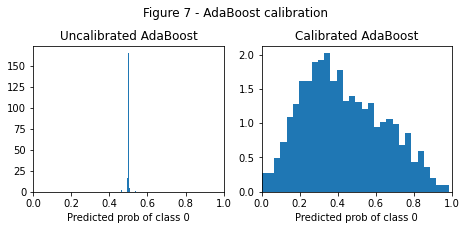

In [60]:
# Show dramatic effect of calibration on AdaBoost predicted probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (7.5, 3))

# Subplot 1
test = model_ada.predict_proba(coupon_test_dummy_new)[:, 0]
ax1.hist(test, density = True, bins = 30);
ax1.set(xlabel = 'Predicted prob of class 0');
ax1.set_title('Uncalibrated AdaBoost');
ax1.set_xlim(0, 1);

# Subplot 2
test2 = calibrated_ada.predict_proba(coupon_test_dummy_new)[:, 0]
ax2.hist(test2, density = True, bins = 30);
ax2.set(xlabel = 'Predicted prob of class 0');
ax2.set_title('Calibrated AdaBoost');
ax2.set_xlim(0, 1);

# Overall title
plt.suptitle('Figure 7 - AdaBoost calibration')
plt.subplots_adjust(top = 0.8)

# Save plot
plt.savefig('Images/AdaBoost_calibration.png', bbox_inches = 'tight')

In [38]:
# Create df to track results of using different coefficients
ensemble_df = pd.DataFrame(columns = ['AdaBoost', 'SVM', 'RF', 'XGB', 'Avg'])

# Try out many different combinations of models
for i in range(1000):

    # Random draw of contributions
    ada_coef = random.uniform(0, 1)
    svm_coef = random.uniform(0, 1)
    rf_coef = random.uniform(0, 1)
    xgb_coef = random.uniform(0, 1)
    total = ada_coef + svm_coef + rf_coef + xgb_coef

    accuracy = np.zeros(10)
    for fold in range(10):
        filter_df = result_df[result_df.Fold == fold]
        combined_probs = (ada_coef * filter_df.iloc[:, 1] + svm_coef * filter_df.iloc[:, 2] + \
        rf_coef * filter_df.iloc[:, 3] + xgb_coef * filter_df.iloc[:, 4]) / total
        preds = [0 if prob >= 0.5 else 1 for prob in combined_probs]
        accuracy[fold] = np.average(preds == filter_df.iloc[:, 5])
    ensemble_df.loc[len(ensemble_df.index)] = [ada_coef / total, svm_coef / total, rf_coef / total, \
                                               xgb_coef / total, np.average(accuracy)]
    
# Display results
ensemble_df.sort_values('Avg', ascending = False).reset_index(drop = True).head(5)

,AdaBoost,SVM,RF,XGB,Avg
0,0.170078,0.467426,0.280440,0.082055,0.784966
1,0.030555,0.569299,0.233043,0.167103,0.784483
2,0.197595,0.472985,0.287395,0.042024,0.783983
3,0.144471,0.483611,0.303343,0.068575,0.783500
4,0.206534,0.457703,0.239741,0.096023,0.783490


In [39]:
# Recalibrate with full training data
# Calibrate AdaBoost
calibrated_ada = CalibratedClassifierCV(base_estimator = model_ada, cv = kf);
calibrated_ada.fit(X_dummy, y);

# Calibrate SVM
calibrated_svm = CalibratedClassifierCV(base_estimator = model_svm, cv = kf);
calibrated_svm.fit(X_dummy, y);

# Calibrate RF
calibrated_rf = CalibratedClassifierCV(base_estimator = model_rf, cv = kf);
calibrated_rf.fit(X_dummy, y);

# Calibrate XGBoost
calibrated_xgb = CalibratedClassifierCV(base_estimator = model_xgb, cv = kf);
calibrated_xgb.fit(X_dummy, y);

In [40]:
# Try out best result on test data
ada_proba_test = ensemble_df.iloc[0, 0] * calibrated_ada.predict_proba(coupon_test_dummy_new)[:,0]
svm_proba_test = ensemble_df.iloc[0, 1] * calibrated_svm.predict_proba(coupon_test_dummy_new)[:,0]
rf_proba_test = ensemble_df.iloc[0, 2] * calibrated_rf.predict_proba(coupon_test_dummy_new)[:,0]
xgb_proba_test = ensemble_df.iloc[0, 3] * calibrated_xgb.predict_proba(coupon_test_dummy_new)[:,0]
combined_probs_test = (ada_proba_test + svm_proba_test + rf_proba_test + xgb_proba_test)
test_preds = [0 if prob >= 0.5 else 1 for prob in combined_probs_test]
np.average(test_preds == test_labels.iloc[:, 1])

0.7724

We'll ultimately compare this test error value with some simpler ensembles later.

Last thing we can try is simple majority vote.

In [41]:
# Predictions
labels_svm = model_svm.predict(coupon_test_dummy_new)
labels_rf = model_rf.predict(coupon_test_dummy_new)
labels_xgb = model_xgb.predict(coupon_test_dummy_new)
labels_ada = model_ada.predict(coupon_test_dummy_new)

# Create predictions
avg = (labels_svm + labels_rf + labels_xgb + labels_ada) / 4
preds = [1 if pred >= 0.5 else 0 for pred in avg]

# Compute accuracy
np.average(preds == test_labels.iloc[:, 1])

0.7724

Show training accuracy for all final models (based on 10-fold CV).

In [42]:
# AdaBoost
print('AdaBoost:', np.average(cross_val(X_dummy_new, y, model_ada)))
print('')

# SVM
print('SVM:', np.average(cross_val(X_dummy_new, y, model_svm)))
print('')

# RF
print('Random Forest:', np.average(cross_val(X_dummy_new, y, model_rf)))
print('')

# XGBoost
print('XGBoost:', np.average(cross_val(X_dummy_new, y, model_xgb)))

AdaBoost: 0.7481326312826435

SVM: 0.7713069556616815

Random Forest: 0.7634513978996319

XGBoost: 0.7653201162201088


Show test accuracy for all of our final models (including ensembles)

In [63]:
# Ensemble: RF + XGB (calibrated)
combined_probs_test = (calibrated_rf.predict_proba(coupon_test_dummy_new)[:, 0] + \
                       calibrated_xgb.predict_proba(coupon_test_dummy_new)[:, 0]) / 2
test_preds = [0 if prob >= 0.5 else 1 for prob in combined_probs_test]
print('Calibrated ensemble (XGB, RF):', np.average(test_preds == test_labels.iloc[:, 1]))
print('')

# Ensemble: SVM + XGB (calibrated)
combined_probs_test = (calibrated_svm.predict_proba(coupon_test_dummy_new)[:, 0] + \
                       calibrated_xgb.predict_proba(coupon_test_dummy_new)[:, 0]) / 2
test_preds = [0 if prob >= 0.5 else 1 for prob in combined_probs_test]
print('Calibrated ensemble (XGB, SVM):', np.average(test_preds == test_labels.iloc[:, 1]))
print('')

# Ensemble: RF + XGB + SVM (calibrated)
combined_probs_test = (calibrated_rf.predict_proba(coupon_test_dummy_new)[:, 0] + \
                       calibrated_xgb.predict_proba(coupon_test_dummy_new)[:, 0] + \
                      calibrated_svm.predict_proba(coupon_test_dummy_new)[:, 0]) / 3
test_preds = [0 if prob >= 0.5 else 1 for prob in combined_probs_test]
print('Calibrated ensemble (XGB, RF, SVM):', np.average(test_preds == test_labels.iloc[:, 1]))
print('')

# Ensemble: RF + XGB
combined_probs_test = (model_rf.predict_proba(coupon_test_dummy_new)[:, 0] + \
                       model_xgb.predict_proba(coupon_test_dummy_new)[:, 0]) / 2
test_preds = [0 if prob >= 0.5 else 1 for prob in combined_probs_test]
print('Ensemble (XGB, RF):', np.average(test_preds == test_labels.iloc[:, 1]))
print('')

# Ensemble: SVM + XGB
combined_probs_test = (model_svm.predict_proba(coupon_test_dummy_new)[:, 0] + \
                       model_xgb.predict_proba(coupon_test_dummy_new)[:, 0]) / 2
test_preds = [0 if prob >= 0.5 else 1 for prob in combined_probs_test]
print('Ensemble (XGB, SVM):', np.average(test_preds == test_labels.iloc[:, 1]))
print('')

# Ensemble: RF + XGB + SVM
combined_probs_test = (model_rf.predict_proba(coupon_test_dummy_new)[:, 0] + \
                       model_xgb.predict_proba(coupon_test_dummy_new)[:, 0] + \
                      model_svm.predict_proba(coupon_test_dummy_new)[:, 0]) / 3
test_preds = [0 if prob >= 0.5 else 1 for prob in combined_probs_test]
print('Ensemble (XGB, RF, SVM):', np.average(test_preds == test_labels.iloc[:, 1]))
print('')

# AdaBoost
print('AdaBoost:', np.average(model_ada.predict(coupon_test_dummy_new) == test_labels.iloc[:, 1]))
print('')

# SVM
print('SVM:', np.average(model_svm.predict(coupon_test_dummy_new) == test_labels.iloc[:, 1]))
print('')

# RF
print('Random Forest:', np.average(model_rf.predict(coupon_test_dummy_new) == test_labels.iloc[:, 1]))
print('')

# XGBoost
print('XGBoost:', np.average(model_xgb.predict(coupon_test_dummy_new) == test_labels.iloc[:, 1]))

Calibrated ensemble (XGB, RF): 0.7776

Calibrated ensemble (XGB, SVM): 0.7792

Calibrated ensemble (XGB, RF, SVM): 0.7772

Ensemble (XGB, RF): 0.774

Ensemble (XGB, SVM): 0.7744

Ensemble (XGB, RF, SVM): 0.7784

AdaBoost: 0.7424

SVM: 0.7668

Random Forest: 0.7556

XGBoost: 0.7628


# Model reliance

In [64]:
def model_reliance_dummy(X_train, y_train, X_test, y_test, X_orig, model, loss):
    
    """Compute model reliance for dummy variable formulation of original data. Rather than treating
    each column of binary variables as independent, we create groupings that resemble the original 22 
    covariates before they were one-hot encoded. The chosen loss function
    is (1 - Accuracy) to allow for easy use with other algorithms.
    
    INPUTS:
    X_train, X_test - Covariate matrix, which is output of pd.get_dummies() function on original data
    y_train, y_test - Accompanying labels for covariate matrices
    X_orig - Original data before transformation with pd.get_dummies() function
    model - A model object to use for fitting and predicting
    loss - Loss function to be used in calculation
    
    OUTPUTS:
    imp_df - Data frame with variable grouping identifiers, error, and model reliance ratio
    """
    
    # Initialize dataframe to store results
    imp_df = pd.DataFrame({'Variable' : X_orig.columns, 'Error': np.zeros(len(X_orig.columns))})
    imp_df.loc[-1] = ['All variables', 0.0]
    imp_df = imp_df.sort_index().reset_index(drop = True)
    
    # Define column groupings
    column_groups = [X_train.columns[0:3].values, X_train.columns[3:7].values, X_train.columns[7:10].values, \
                X_train.columns[10:13].values, X_train.columns[13:18].values, X_train.columns[18:23].values, \
                X_train.columns[23:25].values, X_train.columns[25:27].values, \
                X_train.columns[27:35].values, X_train.columns[35:40].values, \
                X_train.columns[40:42].values, X_train.columns[42:48].values, \
                X_train.columns[48:73].values, X_train.columns[73:82].values, \
                X_train.columns[82:88].values, X_train.columns[88:94].values, \
                X_train.columns[94:100].values, X_train.columns[100:106].values, \
                X_train.columns[106:112].values, X_train.columns[112:114].values, \
                X_train.columns[114:117].values, X_train.columns[117:123].values]
    
    # Fit full model
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    if loss == hinge_loss:
        preds[np.where(preds == 0)] = -1
    imp_df.iloc[0, 1] = loss(y_test, preds)
    
    # Compute model reliance values
    for idx, group in enumerate(column_groups):
        X_test_new = X_test.copy()
        for col in group:
            X_test_new.loc[:, col] = np.random.permutation(X_test.loc[:, col])
        preds = model.predict(X_test_new)
        if loss == hinge_loss:
            preds[np.where(preds == 0)] = -1
        imp_df.iloc[idx + 1, 1] = loss(y_test, preds)

    # Create column for model reliance ratio
    imp_df['Importance'] = imp_df['Error'] / imp_df.iloc[0, 1]
    
    return imp_df

In [65]:
# SVM model reliance
svm_mi = model_reliance_dummy(X_dummy_new, y, coupon_test_dummy_new, test_labels.iloc[:, 1], \
                              X, model_svm, hinge_loss)
svm_mi.sort_values('Error', ascending = False).reset_index(drop = True)

,Variable,Error,Importance
0,Coupon_category_rating,0.5792,1.241852
1,Coupon_validity,0.5264,1.128645
2,Coupon,0.5184,1.111492
3,Income,0.4976,1.066895
4,Occupation,0.4920,1.054889
5,Restaurantlessthan20,0.4872,1.044597
6,Age,0.4856,1.041166
7,Passanger,0.4824,1.034305
8,Gender,0.4808,1.030875
9,Driving_to,0.4800,1.029160


In [66]:
# Random Forest model reliance 
rf_mi = model_reliance_dummy(X_dummy_new, y, coupon_test_dummy_new, test_labels.iloc[:, 1], \
                              X, model_rf, log_loss)
rf_mi.sort_values('Error', ascending = False).reset_index(drop = True)

,Variable,Error,Importance
0,Coupon_category_rating,10.845347,1.362848
1,Coupon,9.436145,1.185765
2,Coupon_validity,9.146007,1.149305
3,Occupation,8.676269,1.090277
4,Restaurantlessthan20,8.662455,1.088541
5,Education,8.634826,1.085069
6,Income,8.579563,1.078125
7,Age,8.579562,1.078125
8,Coffeehouse,8.538114,1.072916
9,Bar,8.469037,1.064236


In [67]:
# AdaBoost model reliance
ada_mi = model_reliance_dummy(X_dummy_new, y, coupon_test_dummy_new, test_labels.iloc[:, 1], \
                              X, model_ada, log_loss)
ada_mi.sort_values('Error', ascending = False).reset_index(drop = True)

,Variable,Error,Importance
0,Coupon_category_rating,12.102557,1.394905
1,Coupon,10.085463,1.162421
2,Occupation,10.002562,1.152866
3,Income,9.947303,1.146497
4,Driving_to,9.560458,1.101910
5,Coupon_validity,9.505202,1.095541
6,Time,9.367043,1.079618
7,Direction_same,9.242696,1.065286
8,Coffeehouse,9.104547,1.049363
9,Temperature,9.076914,1.046178


In [68]:
# XGBoost model reliance
xgb_mi = model_reliance_dummy(X_dummy_new, y, coupon_test_dummy_new, test_labels.iloc[:, 1], \
                              X, model_xgb, log_loss)
xgb_mi.sort_values('Error', ascending = False).reset_index(drop = True)

,Variable,Error,Importance
0,Coupon_category_rating,10.983482,1.407080
1,Coupon,9.546650,1.223009
2,Coupon_validity,9.297961,1.191150
3,Occupation,8.745335,1.120354
4,Maritalstatus,8.496647,1.088495
5,Age,8.482840,1.086726
6,Restaurant20to50,8.455208,1.083186
7,Education,8.455205,1.083185
8,Driving_to,8.427575,1.079646
9,Income,8.413762,1.077876
